<a href="https://colab.research.google.com/github/stupidbutsmart/DELE-CA1/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<style>
  b {
    color: red;
  }
</style>

## Section A CA1 CNN

Name: Jovan Heng Ghim Hong

Class: DAAA/2B/22

Admin No: 2401418

In [66]:
# Basic Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten ,Conv2D, MaxPooling2D , UpSampling2D, Cropping2D
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.preprocessing import image

## for keras classifier i will be using scikeras lib
## 2.12+ no longer supports tensorflow.keras.wrappers.scikit_learn
## this was coded in across different versions (namely 2.10 and 2.19)
from scikeras.wrappers import KerasClassifier


tf.random.set_seed(42)
warnings.filterwarnings('ignore')

### Creating UDFs to aid workflow

Before i start, i want to create some functions that can help me with my work.

basic functions like:
1. create model function
2. autoencoder function
3. data processing functions

etc.

This can help modularize my code (especially since im working with 2 models) and make it easier for future collaborater to understand

In [35]:
DATASET_PATH = './datasets/'

def get_greyscale_data(data_type , size):
  targets = [ target for target in os.listdir(DATASET_PATH + data_type)]

  rows = []
  for target in targets: 
    for file_name in os.listdir(os.path.join(DATASET_PATH , data_type ,  target)):
      # greyscale 
      img = image.load_img(os.path.join(DATASET_PATH , data_type, target , file_name ) ,color_mode='grayscale' , target_size=size)
      img = image.img_to_array(img)
      
      record = {'sequence' : img}
      for t in targets:
        record[t] = 1 if t == target else 0

      rows.append(record)

  return pd.DataFrame(rows , columns=['sequence'] + targets)



In [43]:
STORED_DATA = './stored_data/'
def build_data(size):
  """ size should be a single number n for n x n pixels
  """
  res = []
  for file in os.listdir(STORED_DATA):
    if file.endswith('.json') and (str (size) in file):
      res.append(pd.read_json(os.path.join(STORED_DATA , file)))
  return res

In [44]:
def create_model(
    number_of_layers=3 , number_of_neurons=128,
    optimizer='adam' , activation='relu',
    layers=[Conv2D], # incase i want to add more layers
    strict_follow_layers = False,
    input_shape=(23 , 23 , 3) # follows first layer
):
  model = Sequential()

  # Adding layers
  if strict_follow_layers:
    for layer in layers:
      model.add(layer(number_of_neurons , activation=activation))
  else:
    for i in range(number_of_layers):
      for layer in layers:
        model.add(layer(number_of_neurons , activation=activation))

  model.add(Flatten())
  model.add(Dense(1 , activation='softmax'))
  model.compile(optimizer=optimizer , loss='categorical_crossentropy' , metrics=['accuracy'])

  return KerasClassifier(model)



### Data Cleaning and Exploration

In [38]:
## NOTE
## get_greyscale_data() takes awhile to run
## below there is a function that builds the DF from ./stored_data
## run if ./stored_data was not provided, otherwise run cell with build_data() below
train_data = get_greyscale_data('train' , (23 , 23))

In [39]:
train_data.head()

,sequence,Bean,Bitter_Gourd,Brinjal,Cabbage,Capsicum,Cauliflower and Broccoli,Cucumber and Bottle_Gourd,Potato,Pumpkin,Radish and Carrot,Tomato
0,"[[[34.0], [107.0], [32.0], [29.0], [34.0], [31...",1,0,0,0,0,0,0,0,0,0,0
1,"[[[189.0], [188.0], [186.0], [185.0], [185.0],...",1,0,0,0,0,0,0,0,0,0,0
2,"[[[114.0], [107.0], [93.0], [85.0], [83.0], [7...",1,0,0,0,0,0,0,0,0,0,0
3,"[[[53.0], [55.0], [42.0], [7.0], [140.0], [149...",1,0,0,0,0,0,0,0,0,0,0
4,"[[[162.0], [165.0], [168.0], [165.0], [167.0],...",1,0,0,0,0,0,0,0,0,0,0


In order to save computional time, we will save the data, allowing us to build our df from it.

We are using json format, as integrates seamlessly with my **sequence** column

In [40]:
train_data.to_json(os.path.join(STORED_DATA , 'train_23.json') , orient='records')

## repeat for test and validation
test_data = get_greyscale_data('test' , (23 , 23))
validation_data = get_greyscale_data('validation' , (23 , 23))

test_data.to_json(os.path.join(STORED_DATA , 'test_23.json') , orient='records')
validation_data.to_json(os.path.join(STORED_DATA , 'validation_23.json') , orient='records')

With our data exported, we can reimport it 

In [45]:
test_data , train_data , validation_data = build_data(23)

In [46]:
train_data.head()

,sequence,Bean,Bitter_Gourd,Brinjal,Cabbage,Capsicum,Cauliflower and Broccoli,Cucumber and Bottle_Gourd,Potato,Pumpkin,Radish and Carrot,Tomato
0,"[[[34.0], [107.0], [32.0], [29.0], [34.0], [31...",1,0,0,0,0,0,0,0,0,0,0
1,"[[[189.0], [188.0], [186.0], [185.0], [185.0],...",1,0,0,0,0,0,0,0,0,0,0
2,"[[[114.0], [107.0], [93.0], [85.0], [83.0], [7...",1,0,0,0,0,0,0,0,0,0,0
3,"[[[53.0], [55.0], [42.0], [7.0], [140.0], [149...",1,0,0,0,0,0,0,0,0,0,0
4,"[[[162.0], [165.0], [168.0], [165.0], [167.0],...",1,0,0,0,0,0,0,0,0,0,0


We can recontruct it and plot it using matplotlib 

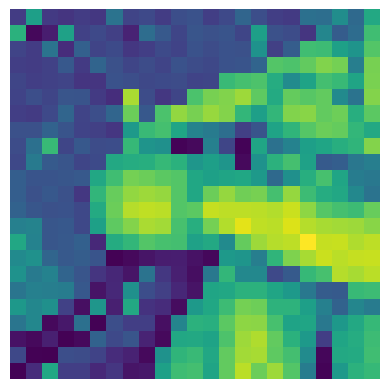

In [47]:
plt.imshow(train_data['sequence'].iloc[0])
plt.axis('off')
plt.show()

##### Comparing it to its real img counterpart
<style>
.two_col_row {
  display: grid;
  grid-template-columns: 1fr 1fr; /* Two equal columns */
  gap: 20px; /* Space between items */
  padding: 20px
}

img {
  height: auto;
  width: 100%;
}



  </style>
<div class='two_col_row'>
  <img src='./markdown/bean_1_reconstruction.png'>
  <img src='./markdown/bean_1_original.jpg'>
</div>




Simply from the first image of **Bean**, it is already not a bean but a **carrot**

Manual Inspection of the **training** data shows that there is a **large majority of beans** in the bean dataset but there are **a small amount of mislabelled vegetables**

##### Solution? 

We are going to **create an autoencoder** and **use the bottleneck to detect abnomalies**

In [48]:
train_data.size

92520

In [67]:
# Creating the autoencoder
# We do not need to tune this encoder, we want to keep it simple (generalize well)

autoencoder = Sequential([
  # encoding part
  Conv2D(filters=128 , kernel_size=(3 , 3) , activation='relu' , input_shape=(23 , 23 , 1), padding='same'),
  MaxPooling2D((2 , 2), padding='same'),
  Conv2D(filters=32 , kernel_size=(3 , 3) , activation='relu', padding='same'), # bottleneck / compressed layer (32 features)
  # decoding part
  UpSampling2D((2 , 2)),
  Conv2D(filters=32 , kernel_size=(3 , 3) , activation='relu', padding='same'),
  Cropping2D(cropping=((0,1) , (0,1))), # ensures output is 23x23
  Conv2D(filters=1 , kernel_size=(3 , 3) , activation='sigmoid', padding='same') # output layer
])
autoencoder.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 23, 23, 128)       1280      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 12, 128)      0         
 2D)                                                             
                                                                 
 conv2d_21 (Conv2D)          (None, 12, 12, 32)        36896     
                                                                 
 up_sampling2d_6 (UpSampling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_22 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 cropping2d (Cropping2D)     (None, 23, 23, 32)       

In [68]:
# compile and train
autoencoder.compile(loss='binary_crossentropy' , optimizer='adam')

X_train = np.stack(train_data['sequence'].values)

# X_train for both since we dont actually use the y labels
autoencoder.fit(X_train , X_train , epochs=30)

Epoch 1/30
241/241 [==============================] - 16s 65ms/step - loss: -41182695424.0000
Epoch 2/30
241/241 [==============================] - 16s 65ms/step - loss: -2068607664128.0000
Epoch 3/30
241/241 [==============================] - 15s 64ms/step - loss: -16363092443136.0000
Epoch 4/30
241/241 [==============================] - 15s 64ms/step - loss: -62373863882752.0000
Epoch 5/30
241/241 [==============================] - 15s 64ms/step - loss: -165307721187328.0000
Epoch 6/30
241/241 [==============================] - 15s 63ms/step - loss: -353923323920384.0000
Epoch 7/30
241/241 [==============================] - 15s 63ms/step - loss: -657200527704064.0000
Epoch 8/30
241/241 [==============================] - 15s 62ms/step - loss: -1103595940347904.0000
Epoch 9/30
241/241 [==============================] - 16s 66ms/step - loss: -1720837971378176.0000
Epoch 10/30
241/241 [==============================] - 19s 78ms/step - loss: -2536271603826688.0000
Epoch 11/30
241/241 [===